In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [61]:
df_train = pd.read_csv("job_data_files/salary_labelled_development_set.csv")
df_train.columns

Index(['job_id', 'job_title', 'job_ad_details', 'nation_short_desc',
       'salary_additional_text', 'y_true'],
      dtype='object')

In [45]:
# average length of job title, job ad details and salary additional text
df_train["job_title"].str.len().mean(), df_train[
    "job_ad_details"
].str.len().mean(), df_train["salary_additional_text"].str.len().mean()

(33.242611380679314, 2500.572562858403, 16.752417794970988)

In [63]:
# Remove html tags from job_ad_details
df_train["job_ad_details"] = df_train["job_ad_details"].str.replace(
    r"<[^>]+>", " ", regex=True
)

# Remove html & characters from job_ad_details
df_train["job_ad_details"] = df_train["job_ad_details"].str.replace(
    r"&[a-zA-Z0-9]+;", " ", regex=True
)

# Remove escaped characters from job_ad_details
df_train["job_ad_details"] = df_train["job_ad_details"].str.replace(
    r"\\[a-zA-Z0-9]+", " ", regex=True
)

# Merge multiple spaces into one
df_train["job_ad_details"] = df_train["job_ad_details"].str.replace(
    r"\s+", " ", regex=True
)

df_train["job_ad_details"].str.len().mean()

2072.5659461843848

In [47]:
# Expand y_true into 4 columns using the split function
new_columns = ["y_true_min_sal", "y_true_max_sal", "y_true_curr", "y_true_freq"]
df_train[new_columns] = df_train["y_true"].str.split("-", expand=True, n=3)

# min_sal and max_sal are integers, curr and freq are strings
df_train["y_true_min_sal"] = df_train["y_true_min_sal"].astype(float)
df_train["y_true_max_sal"] = df_train["y_true_max_sal"].astype(float)
df_train["y_true_curr"] = df_train["y_true_curr"].astype(str).str.strip()
df_train["y_true_freq"] = df_train["y_true_freq"].astype(str).str.strip()

# Parse empty columns to None
df_train.loc[df_train["y_true_min_sal"] == 0.0, "y_true_min_sal"] = None
df_train.loc[df_train["y_true_max_sal"] == 0.0, "y_true_max_sal"] = None
df_train.loc[df_train["y_true_curr"] == "None", "y_true_curr"] = None
df_train.loc[df_train["y_true_freq"] == "None", "y_true_freq"] = None

# Count missing values in each column
print("Percentage of missing values in each column:")
df_train.isnull().sum() / len(df_train) * 100

Percentage of missing values in each column:


job_id                     0.000000
job_title                  0.000000
job_ad_details             0.000000
nation_short_desc          0.000000
salary_additional_text    54.389060
y_true                     0.000000
y_true_min_sal            41.905602
y_true_max_sal            41.905602
y_true_curr               41.905602
y_true_freq               41.905602
dtype: float64

In [48]:
# Merge all the columns into a single text column
df_train["text"] = (
    (
        df_train["job_title"]
        + " "
        + df_train["job_ad_details"]
        + " "
        + df_train["salary_additional_text"]
    )
    .astype(str)
    .str.strip()
)

In [66]:
df_train_filtered = df_train.dropna(
    subset=["y_true_min_sal", "y_true_max_sal", "y_true_curr", "y_true_freq"]
).copy()
print("Filtered dataset shape:", df_train_filtered.shape)

df_train_filtered["y_true_min_sal"] = df_train_filtered["y_true_min_sal"].astype(int)
df_train_filtered["y_true_max_sal"] = df_train_filtered["y_true_max_sal"].astype(int)
df_train_filtered["y_true_curr"] = df_train_filtered["y_true_curr"].astype(str)
df_train_filtered["y_true_freq"] = df_train_filtered["y_true_freq"].astype(str)

# Count missing values in each column
print("Percentage of missing values in each column:")
print(df_train_filtered.isnull().sum() / len(df_train_filtered) * 100)

df_train_filtered["salary_additional_text"] = df_train_filtered[
    "salary_additional_text"
].astype(str)
df_train_filtered["job_ad_details"] = df_train_filtered["job_ad_details"].astype(str)

KeyError: ['y_true_min_sal', 'y_true_max_sal', 'y_true_curr', 'y_true_freq']

In [26]:
import re

find_col_in_col = lambda c1, c2: (
    lambda x: bool(re.search(rf"[-$]?{x[c1]}[$]?", x[c2]))
    or bool(re.search(rf"[-$]?{format(x[c1],',')}[$]?", x[c2]))
    or bool(re.search(rf"[-$]?{x[c1]+1}[$]?", x[c2]))
    or bool(re.search(rf"[-$]?{format(x[c1]+1,',')}[$]?", x[c2]))
    or bool(re.search(rf"[-$]?{x[c1]-1}[$]?", x[c2]))
    or bool(re.search(rf"[-$]?{format(x[c1]-1,',')}[$]?", x[c2]))
)


df_tf_sad = df_train_filtered[
    df_train_filtered["salary_additional_text"].str.strip() != "nan"
].copy()
print(len(df_tf_sad))

# Find columns with y_true_min_sal and y_true_max_sal strictly contained in the text feature column
df_tf_sad["max_sal_in_ad"] = df_tf_sad.apply(
    find_col_in_col("y_true_max_sal", "job_ad_details"), axis=1
)
trivial_in_jad = df_tf_sad["max_sal_in_ad"].sum()


df_tf_sad["max_sal_in_sat"] = df_tf_sad.apply(
    find_col_in_col("y_true_max_sal", "salary_additional_text"), axis=1
)
trivial_in_sat = df_tf_sad["max_sal_in_sat"].sum()


print("Trivial in JAD %:", trivial_in_jad / len(df_tf_sad) * 100)

trivial_in_jad, trivial_in_sat, trivial_in_sat / trivial_in_jad * 100

625
Trivial in JAD %: 99.83999999999999


(624, 539, 86.37820512820514)

In [27]:
df_tf_sad[~df_tf_sad["max_sal_in_ad"]]

,job_id,job_title,job_ad_details,nation_short_desc,salary_additional_text,y_true,y_true_min_sal,y_true_max_sal,y_true_curr,y_true_freq,text,max_sal_in_ad,max_sal_in_sat
51,66860093,Project Assistant Manager (Lighting/Electrical),". Our client is a ""Lighting Specialist"" which ...",SG,"$1,000 - $1,375 per week",4000-5500-SGD-WEEKLY,4000,5500,SGD,WEEKLY,Project Assistant Manager (Lighting/Electrical...,False,False


In [28]:
# Find columns with y_true_min_sal and y_true_max_sal strictly contained in the text feature column
df_tf_no_sad = df_train_filtered[
    df_train_filtered["salary_additional_text"].str.strip() == "nan"
].copy()
print(len(df_tf_no_sad))

df_tf_no_sad["max_sal_in_ad"] = df_tf_no_sad.apply(
    find_col_in_col("y_true_max_sal", "job_ad_details"), axis=1
)
trivial_in_text = df_tf_no_sad["max_sal_in_ad"].sum()

trivial_in_text / len(df_tf_no_sad) * 100

692


99.71098265895954

In [29]:
df_tf_no_sad[~df_tf_no_sad["max_sal_in_ad"]]


,job_id,job_title,job_ad_details,nation_short_desc,salary_additional_text,y_true,y_true_min_sal,y_true_max_sal,y_true_curr,y_true_freq,text,max_sal_in_ad
162,75182600,Kitchen Assistant,. . . Your future workplace. . Sacred Heart ...,AUS,nan,26-26-AUD-HOURLY,26,26,AUD,HOURLY,nan,False
757,60154245,Delivery Agent - EBike,. . Delivery Agent - EBike | Levin | On Call&#...,NZ,nan,25-27-NZD-HOURLY,25,27,NZD,HOURLY,nan,False


In [30]:
df_train_filtered[df_train_filtered["y_true_min_sal"] < 10]

,job_id,job_title,job_ad_details,nation_short_desc,salary_additional_text,y_true,y_true_min_sal,y_true_max_sal,y_true_curr,y_true_freq,text
302,78518295,Work from Home Remote Tele-Sales For Personal ...,. . Job Description :. . . This is a fully rem...,MY,nan,9-12-MYR-HOURLY,9,12,MYR,HOURLY,nan
413,79224115,Part Time Telemarketer (Entry Level),. Join our team as a Telemarketer where you wi...,SG,nan,8-13-SGD-HOURLY,8,13,SGD,HOURLY,nan
579,75949163,Admin assistant,. \n. \n. My Art Studio (Singapore) We are pas...,SG,nan,9-10-SGD-HOURLY,9,10,SGD,HOURLY,nan
2218,78492074,Assistant Commercial Manager (Ref:240001BJ),. . Responsibilities. . \n\n. . Ensure the med...,HK,nan,1-2-HKD-MONTHLY,1,2,HKD,MONTHLY,nan


In [31]:
df_train_filtered[df_train_filtered["y_true_max_sal"] > 1000000]

,job_id,job_title,job_ad_details,nation_short_desc,salary_additional_text,y_true,y_true_min_sal,y_true_max_sal,y_true_curr,y_true_freq,text
365,74822086,content creator,. (TIKTOK mostly).. . Able to think and create...,ID,"Rp 10,000,000 – Rp 15,000,000 per month",10000000-15000000-IDR-MONTHLY,10000000,15000000,IDR,MONTHLY,content creator . (TIKTOK mostly).. . Able to ...
1057,75111634,Waitress,. harus bisa bahasa ingris. . welcome the cust...,ID,nan,3165000-3165000-IDR-MONTHLY,3165000,3165000,IDR,MONTHLY,nan
1153,71195408,Financial assistant,. Job title: Financial Assistant. . Location: ...,ID,"Rp 10,000,000 – Rp 15,000,000 per month",10000000-15000000-IDR-MONTHLY,10000000,15000000,IDR,MONTHLY,Financial assistant . Job title: Financial Ass...
1393,74122021,翻译助手（普通话翻译）,. 招贤纳士，职等你来. . 仓库助理能通过普通话熟练交流~~. . 要求：. . 1、年龄...,ID,Rp 8.000.000 – Rp 10.000.000 per month,8000000-10000000-IDR-MONTHLY,8000000,10000000,IDR,MONTHLY,翻译助手（普通话翻译） . 招贤纳士，职等你来. . 仓库助理能通过普通话熟练交流~~. ....
1956,75642884,Waiter/Waitress,. harus bisa bahasa ingris. . welcome the cust...,ID,nan,3200000-3200000-IDR-MONTHLY,3200000,3200000,IDR,MONTHLY,nan


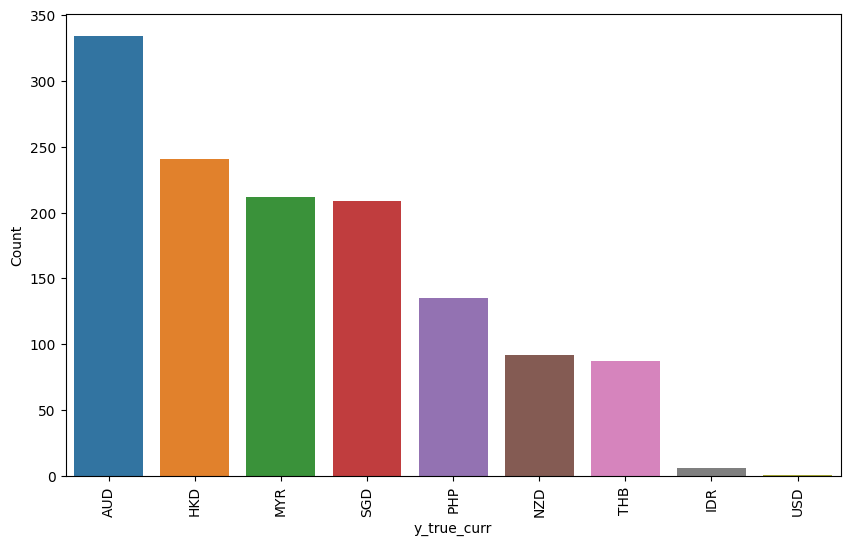

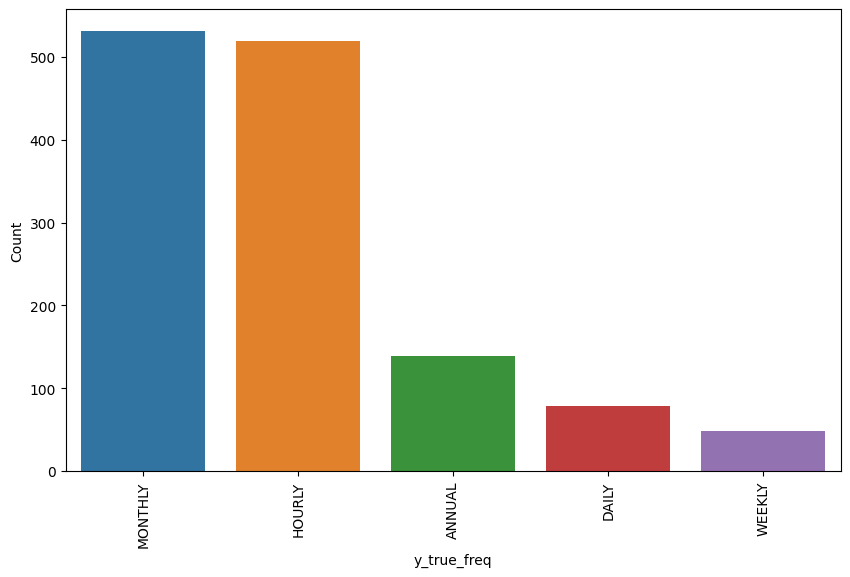

In [32]:
# Plot distribution sorted of all y_true values
import matplotlib.pyplot as plt

import seaborn as sns

# Histogram of y_true_min_sal and y_true_max_sal
# for col in ["y_true_min_sal", "y_true_max_sal"]:
#     # For each currency, plot the distribution of y_true_min_sal and y_true_max_sal
#     for currency in df_train_filtered["y_true_curr"].unique():
#         plt.figure(figsize=(10, 6))
#         sns.histplot(
#             data=df_train_filtered[df_train_filtered["y_true_curr"] == currency],
#             x=col,
#             bins=20,
#             kde=True,
#         )
#         plt.title(f"Distribution of {col} for {currency}")
#         plt.xlabel(col)
#         plt.ylabel("Density")
#         plt.show()

for col in ["y_true_curr", "y_true_freq"]:
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # barplot of sorted value counts
    sns.countplot(
        data=df_train_filtered, x=col, order=df_train_filtered[col].value_counts().index
    )
    plt.xticks(rotation=90)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [33]:
df_train_filtered["y_true_freq"].value_counts()

MONTHLY    531
HOURLY     519
ANNUAL     139
DAILY       79
WEEKLY      49
Name: y_true_freq, dtype: int64

In [ ]:
freq_keywords = {
    "HOURLY": ["per hour", "hourly", "p.h", "ph"],
    "DAILY": ["per day", "daily", "p.d", "pd"],
    "WEEKLY": ["per week", "weekly", "p.w"],
    "MONTHLY": ["per month", "monthly", "p.m"],
    "ANNUAL": ["per year", "yearly", "annually", "p.a", "p.y"],
}


def predict_freq_baseline(text: str):
    """Predict the frequency of salary based on the text.
    Args:
        text (str): The text to predict the frequency from.

    Returns:
        str: The predicted frequency.
    """
    text = text.lower()
    for freq, keywords in freq_keywords.items():
        for keyword in keywords:
            # Use regex to match \bkeyword\b to avoid partial matches
            if re.search(rf"\b{keyword}\b", text):
                return freq
    return "MONTHLY"


df_train_filtered["y_pred_freq"] = df_train_filtered["text"].apply(
    predict_freq_baseline
)

# accuracy of the frequency prediction

accuracy = accuracy_score(
    df_train_filtered["y_true_freq"].str.lower(),
    df_train_filtered["y_pred_freq"].str.lower(),
)
print(f"Accuracy of frequency prediction: {accuracy:.2%}")

Accuracy of frequency prediction: 61.20%


In [69]:
country_to_currency = {
    "AUS": "AUD",
    "HK": "HKD",
    "MY": "MYR",
    "SG": "SGD",
    "PH": "PHP",
    "NZ": "NZD",
    "TH": "THB",
    "ID": "IDR",
    "US": "USD",
}


def predict_currency_baseline(x) -> str:
    """Predict the currency of salary based on the country code.
    Args:
        x (pd.Series): The row of the dataframe containing the text and country code.

    Returns:
        str: The predicted currency.
    """
    country_code = x["nation_short_desc"].strip().upper()
    # Check if the country code is in the dictionary
    if country_code in country_to_currency:
        return country_to_currency[country_code]

    # If no keywords match, return most common currency in the dataset
    return "IDR"

df_train_filtered["y_pred_curr"] = df_train_filtered.apply(
    predict_currency_baseline, axis=1
)


# accuracy of the currency prediction
accuracy = accuracy_score(
    df_train_filtered["y_true_curr"].str.lower(),
    df_train_filtered["y_pred_curr"].str.lower(),
)
print(f"Accuracy of currency prediction: {accuracy:.2%}")

df_train_filtered[df_train_filtered["y_pred_curr"] != df_train_filtered["y_true_curr"]].head(5)

Accuracy of currency prediction: 99.77%


,job_id,job_title,job_ad_details,nation_short_desc,salary_additional_text,y_true,y_true_min_sal,y_true_max_sal,y_true_curr,y_true_freq,text,y_pred_curr
898,70773107,Project Engineer [ Fire Protection ],. . Working Days: 5 days' work week. . Working...,SG,$625 - $875 per week,625-875-USD-WEEKLY,625,875,USD,WEEKLY,Project Engineer [ Fire Protection ] . . Worki...,SGD
1935,72040955,Gardener,. We are a small Property Maintenance company ...,NZ,Rp 24 per hour,24-24-IDR-HOURLY,24,24,IDR,HOURLY,Gardener . We are a small Property Maintenance...,NZD
2157,76752012,HIRING NATIVE THAI ONLINE ENGLISH EXAMINERS,. Kyna Pte. Ltd. (Kyna English) is an online e...,SG,nan,150-200-THB-HOURLY,150,200,THB,HOURLY,nan,SGD


Job 70773107 is clearly an error, since features dont mention USD at all and its a job in singapore, so it should be in SGD.
In Job 72040955 only the salary additional text mentions the currency
Job 76752012 is an exception, where the job is online and they are not paying in the country's currency